# Infraestrutura inicial(imports, funções auxiliares, etc)

In [1]:
import pandas as pd
import numpy as np
import os
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import seasonal
from matplotlib import pyplot as plt
from functools import reduce  # Operação de reduce para cálculo de média de uma lista
from datetime import datetime
%matplotlib inline

#Configurações para exibição de tableas
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Nomes das colunas adicionadas ao dataframe
COLUNA_ANOMALIA_ACUMULADA = "anomalia_acumulada"
COLUNA_ANOMALIA_DO_MES = "anomalia_mensal"
COLUNA_MEDIA_MENSAL = "media_mensal"

# Todo mês possui 25 linhas por 38 colunas que dá 950
BLOCO_DE_DADOS_DE_UM_MES = 950
QUANTIDADE_DE_VALORES_DO_ARQUIVO = 573800  # (950 blocos x 604 meses,01/1964 até 04/2014)


def constroi_colunas_latitude_longitude():
    w_values = range(60, 0, -2)
    e_values = range(0, 15, 2)
    n_values = range(30, 0, -2)
    s_values = range(0, 20, 2)

    colunas = []
    linhas = []

    # LINHAS
    for value in w_values:
        column_name = str(value) + "W"
        linhas.append(column_name)

    for value in e_values:
        column_name = str(value) + "E"
        linhas.append(column_name)

    # COLUNAS
    for value in n_values:
        column_name = str(value) + "N"
        colunas.append(column_name)

    for value in s_values:
        column_name = str(value) + "S"
        colunas.append(column_name)

    colunas_do_data_frame = []
    for linha in linhas:
        for coluna in colunas:
            lat_long = linha + "-" + coluna
            colunas_do_data_frame.append(lat_long)
    return colunas_do_data_frame


def carrega_array_com_valores_do_arquivo_geral(
        arquivo_com_decadas_de_anomalia="funceme_db/anomalia/geral/_Dados_TSMvento_2014_04_anomt6414b04"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO

    conteudo_do_arquivo = open(arquivo_com_decadas_de_anomalia).read()
    conteudo_do_arquivo = conteudo_do_arquivo.replace("\n", "")

    # Carrega todos os dados de anomalia em um único array
    qtd_char_no_arquivo = 5
    # Todos os valores do arquivo em um único array. Não há separação de mês. Tudo está de forma sequencial
    valores_do_arquivo = []
    for rows_index in range(QUANTIDADE_DE_VALORES_DO_ARQUIVO):
        # slice data like (n:n+5)
        value = float(conteudo_do_arquivo[
                      rows_index * qtd_char_no_arquivo: rows_index * qtd_char_no_arquivo + qtd_char_no_arquivo])
        value /= 10
        valores_do_arquivo.append(value)
    return valores_do_arquivo


def carrega_array_com_valores_do_arquivo_mensal(file_name):
    file_content = open(file_name).read()

    # Remove header de um único arquivo
    file_content = file_content[25:]
    file_content = file_content.replace("\n", "")

    block_size = 5
    dados_do_arquivo = []
    for rows_index in range(BLOCO_DE_DADOS_DE_UM_MES):
        # slice data like (n:n+5)
        value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
        value /= 10
        dados_do_arquivo.append(value)

    return dados_do_arquivo


def merge_dados_do_diretorio(diretorio_anomalia_individual="funceme_db/anomalia/individual/"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO
    lista_de_arquivos_individuais = []
    arquivos_do_diretorio = os.listdir(diretorio_anomalia_individual)

    quantidade_de_arquivos = 0
    # Adiciona apenas arquivos com extensão .22
    for arquivo in arquivos_do_diretorio:
        if arquivo.endswith(".22"):
            lista_de_arquivos_individuais.append(arquivo)
            quantidade_de_arquivos += 1

    valores_dos_arquivos = carrega_array_com_valores_do_arquivo_geral()
    # Para cada arquivo na lista é feito append na lista full_data
    for arquivo in lista_de_arquivos_individuais:
        dados_mensais = carrega_array_com_valores_do_arquivo_mensal(diretorio_anomalia_individual + arquivo)
        for item in dados_mensais:
            valores_dos_arquivos.append(item)

    ##44 meses de 05/2014 até 12/2017
    QUANTIDADE_DE_VALORES_DO_ARQUIVO += quantidade_de_arquivos * BLOCO_DE_DADOS_DE_UM_MES  # Que dá 41800

    array_de_anomalias_por_mes = []
    for i in range(0, QUANTIDADE_DE_VALORES_DO_ARQUIVO, 950):
        anomalias_do_mes = valores_dos_arquivos[i:i + BLOCO_DE_DADOS_DE_UM_MES]
        array_de_anomalias_por_mes.append(anomalias_do_mes)
    return array_de_anomalias_por_mes


def inicia_funceme_data_frame():
    funceme_df = pd.DataFrame()
    for anomalias_do_mes in array_de_anomalias_por_mes:
        data = np.array(anomalias_do_mes)
        row_df = pd.DataFrame(data.reshape(-1, len(data)), columns=constroi_colunas_latitude_longitude())
        funceme_df = funceme_df.append(row_df)
    funceme_df.index = range(0, len(array_de_anomalias_por_mes), 1)
    # ### Setando indices baseados na data
    FORMAT = "%Y-%m"
    some_date_time1 = "1964-01"
    data_inicial = datetime.strptime(some_date_time1, FORMAT)
    indexes_data = []
    for i in range(len(array_de_anomalias_por_mes)):
        indexes_data.append(data_inicial + relativedelta(months=i))
    funceme_df = funceme_df.set_index(pd.DatetimeIndex(data=indexes_data))
    
    return funceme_df


/Users/Tiago/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Carregando dados da FUNCEME

In [2]:

array_de_anomalias_por_mes = merge_dados_do_diretorio()
funceme_df = inicia_funceme_data_frame()


height has been deprecated.



In [3]:
funceme_df.head(2)

,60W-30N,60W-28N,60W-26N,60W-24N,60W-22N,60W-20N,60W-18N,60W-16N,60W-14N,60W-12N,60W-10N,60W-8N,60W-6N,60W-4N,60W-2N,60W-0S,60W-2S,60W-4S,60W-6S,60W-8S,60W-10S,60W-12S,60W-14S,60W-16S,60W-18S,58W-30N,58W-28N,58W-26N,58W-24N,58W-22N,58W-20N,58W-18N,58W-16N,58W-14N,58W-12N,58W-10N,58W-8N,58W-6N,58W-4N,58W-2N,58W-0S,58W-2S,58W-4S,58W-6S,58W-8S,58W-10S,58W-12S,58W-14S,58W-16S,58W-18S,56W-30N,56W-28N,56W-26N,56W-24N,56W-22N,56W-20N,56W-18N,56W-16N,56W-14N,56W-12N,56W-10N,56W-8N,56W-6N,56W-4N,56W-2N,56W-0S,56W-2S,56W-4S,56W-6S,56W-8S,56W-10S,56W-12S,56W-14S,56W-16S,56W-18S,54W-30N,54W-28N,54W-26N,54W-24N,54W-22N,54W-20N,54W-18N,54W-16N,54W-14N,54W-12N,54W-10N,54W-8N,54W-6N,54W-4N,54W-2N,54W-0S,54W-2S,54W-4S,54W-6S,54W-8S,54W-10S,54W-12S,54W-14S,54W-16S,54W-18S,52W-30N,52W-28N,52W-26N,52W-24N,52W-22N,52W-20N,52W-18N,52W-16N,52W-14N,52W-12N,52W-10N,52W-8N,52W-6N,52W-4N,52W-2N,52W-0S,52W-2S,52W-4S,52W-6S,52W-8S,52W-10S,52W-12S,52W-14S,52W-16S,52W-18S,50W-30N,50W-28N,50W-26N,50W-24N,50W-22N,50W-20N,50W-18N,50W-16N,50W-14N,50W-12N,50W-10N,50W-8N,50W-6N,50W-4N,50W-2N,50W-0S,50W-2S,50W-4S,50W-6S,50W-8S,50W-10S,50W-12S,50W-14S,50W-16S,50W-18S,48W-30N,48W-28N,48W-26N,48W-24N,48W-22N,48W-20N,48W-18N,48W-16N,48W-14N,48W-12N,48W-10N,48W-8N,48W-6N,48W-4N,48W-2N,48W-0S,48W-2S,48W-4S,48W-6S,48W-8S,48W-10S,48W-12S,48W-14S,48W-16S,48W-18S,46W-30N,46W-28N,46W-26N,46W-24N,46W-22N,46W-20N,46W-18N,46W-16N,46W-14N,46W-12N,46W-10N,46W-8N,46W-6N,46W-4N,46W-2N,46W-0S,46W-2S,46W-4S,46W-6S,46W-8S,46W-10S,46W-12S,46W-14S,46W-16S,46W-18S,44W-30N,44W-28N,44W-26N,44W-24N,44W-22N,44W-20N,44W-18N,44W-16N,44W-14N,44W-12N,44W-10N,44W-8N,44W-6N,44W-4N,44W-2N,44W-0S,44W-2S,44W-4S,44W-6S,44W-8S,44W-10S,44W-12S,44W-14S,44W-16S,44W-18S,42W-30N,42W-28N,42W-26N,42W-24N,42W-22N,42W-20N,42W-18N,42W-16N,42W-14N,42W-12N,42W-10N,42W-8N,42W-6N,42W-4N,42W-2N,42W-0S,42W-2S,42W-4S,42W-6S,42W-8S,42W-10S,42W-12S,42W-14S,42W-16S,42W-18S,...,4W-30N,4W-28N,4W-26N,4W-24N,4W-22N,4W-20N,4W-18N,4W-16N,4W-14N,4W-12N,4W-10N,4W-8N,4W-6N,4W-4N,4W-2N,4W-0S,4W-2S,4W-4S,4W-6S,4W-8S,4W-10S,4W-12S,4W-14S,4W-16S,4W-18S,2W-30N,2W-28N,2W-26N,2W-24N,2W-22N,2W-20N,2W-18N,2W-16N,2W-14N,2W-12N,2W-10N,2W-8N,2W-6N,2W-4N,2W-2N,2W-0S,2W-2S,2W-4S,2W-6S,2W-8S,2W-10S,2W-12S,2W-14S,2W-16S,2W-18S,0E-30N,0E-28N,0E-26N,0E-24N,0E-22N,0E-20N,0E-18N,0E-16N,0E-14N,0E-12N,0E-10N,0E-8N,0E-6N,0E-4N,0E-2N,0E-0S,0E-2S,0E-4S,0E-6S,0E-8S,0E-10S,0E-12S,0E-14S,0E-16S,0E-18S,2E-30N,2E-28N,2E-26N,2E-24N,2E-22N,2E-20N,2E-18N,2E-16N,2E-14N,2E-12N,2E-10N,2E-8N,2E-6N,2E-4N,2E-2N,2E-0S,2E-2S,2E-4S,2E-6S,2E-8S,2E-10S,2E-12S,2E-14S,2E-16S,2E-18S,4E-30N,4E-28N,4E-26N,4E-24N,4E-22N,4E-20N,4E-18N,4E-16N,4E-14N,4E-12N,4E-10N,4E-8N,4E-6N,4E-4N,4E-2N,4E-0S,4E-2S,4E-4S,4E-6S,4E-8S,4E-10S,4E-12S,4E-14S,4E-16S,4E-18S,6E-30N,6E-28N,6E-26N,6E-24N,6E-22N,6E-20N,6E-18N,6E-16N,6E-14N,6E-12N,6E-10N,6E-8N,6E-6N,6E-4N,6E-2N,6E-0S,6E-2S,6E-4S,6E-6S,6E-8S,6E-10S,6E-12S,6E-14S,6E-16S,6E-18S,8E-30N,8E-28N,8E-26N,8E-24N,8E-22N,8E-20N,8E-18N,8E-16N,8E-14N,8E-12N,8E-10N,8E-8N,8E-6N,8E-4N,8E-2N,8E-0S,8E-2S,8E-4S,8E-6S,8E-8S,8E-10S,8E-12S,8E-14S,8E-16S,8E-18S,10E-30N,10E-28N,10E-26N,10E-24N,10E-22N,10E-20N,10E-18N,10E-16N,10E-14N,10E-12N,10E-10N,10E-8N,10E-6N,10E-4N,10E-2N,10E-0S,10E-2S,10E-4S,10E-6S,10E-8S,10E-10S,10E-12S,10E-14S,10E-16S,10E-18S,12E-30N,12E-28N,12E-26N,12E-24N,12E-22N,12E-20N,12E-18N,12E-16N,12E-14N,12E-12N,12E-10N,12E-8N,12E-6N,12E-4N,12E-2N,12E-0S,12E-2S,12E-4S,12E-6S,12E-8S,12E-10S,12E-12S,12E-14S,12E-16S,12E-18S,14E-30N,14E-28N,14E-26N,14E-24N,14E-22N,14E-20N,14E-18N,14E-16N,14E-14N,14E-12N,14E-10N,14E-8N,14E-6N,14E-4N,14E-2N,14E-0S,14E-2S,14E-4S,14E-6S,14E-8S,14E-10S,14E-12S,14E-14S,14E-16S,14E-18S
1964-01-01,0.4,0.4,0.5,0.5,0.5,0.5,0.4,0.2,0.0,0.0,0.1,0.1,0.6,0.0,0.0,0.0,-0.1,-0.1,-0.3,-0.2,0.0,0.2,0.3,0.2,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,0.3,0.5,0.5,0.6,0.5,0.4,0.4,0.1,0.0,0.0,0.0,0.2,0.1,0.1,0.1,0.3,0.2,0.1,-0.1,-0.1,0.2,0.4,0.4,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.

## Filtra dados por período jan/2009 até dez/2017

In [4]:
funceme_df = funceme_df.loc['2009-01-01':'2017-12-01']
funceme_df.head(2)


,60W-30N,60W-28N,60W-26N,60W-24N,60W-22N,60W-20N,60W-18N,60W-16N,60W-14N,60W-12N,60W-10N,60W-8N,60W-6N,60W-4N,60W-2N,60W-0S,60W-2S,60W-4S,60W-6S,60W-8S,60W-10S,60W-12S,60W-14S,60W-16S,60W-18S,58W-30N,58W-28N,58W-26N,58W-24N,58W-22N,58W-20N,58W-18N,58W-16N,58W-14N,58W-12N,58W-10N,58W-8N,58W-6N,58W-4N,58W-2N,58W-0S,58W-2S,58W-4S,58W-6S,58W-8S,58W-10S,58W-12S,58W-14S,58W-16S,58W-18S,56W-30N,56W-28N,56W-26N,56W-24N,56W-22N,56W-20N,56W-18N,56W-16N,56W-14N,56W-12N,56W-10N,56W-8N,56W-6N,56W-4N,56W-2N,56W-0S,56W-2S,56W-4S,56W-6S,56W-8S,56W-10S,56W-12S,56W-14S,56W-16S,56W-18S,54W-30N,54W-28N,54W-26N,54W-24N,54W-22N,54W-20N,54W-18N,54W-16N,54W-14N,54W-12N,54W-10N,54W-8N,54W-6N,54W-4N,54W-2N,54W-0S,54W-2S,54W-4S,54W-6S,54W-8S,54W-10S,54W-12S,54W-14S,54W-16S,54W-18S,52W-30N,52W-28N,52W-26N,52W-24N,52W-22N,52W-20N,52W-18N,52W-16N,52W-14N,52W-12N,52W-10N,52W-8N,52W-6N,52W-4N,52W-2N,52W-0S,52W-2S,52W-4S,52W-6S,52W-8S,52W-10S,52W-12S,52W-14S,52W-16S,52W-18S,50W-30N,50W-28N,50W-26N,50W-24N,50W-22N,50W-20N,50W-18N,50W-16N,50W-14N,50W-12N,50W-10N,50W-8N,50W-6N,50W-4N,50W-2N,50W-0S,50W-2S,50W-4S,50W-6S,50W-8S,50W-10S,50W-12S,50W-14S,50W-16S,50W-18S,48W-30N,48W-28N,48W-26N,48W-24N,48W-22N,48W-20N,48W-18N,48W-16N,48W-14N,48W-12N,48W-10N,48W-8N,48W-6N,48W-4N,48W-2N,48W-0S,48W-2S,48W-4S,48W-6S,48W-8S,48W-10S,48W-12S,48W-14S,48W-16S,48W-18S,46W-30N,46W-28N,46W-26N,46W-24N,46W-22N,46W-20N,46W-18N,46W-16N,46W-14N,46W-12N,46W-10N,46W-8N,46W-6N,46W-4N,46W-2N,46W-0S,46W-2S,46W-4S,46W-6S,46W-8S,46W-10S,46W-12S,46W-14S,46W-16S,46W-18S,44W-30N,44W-28N,44W-26N,44W-24N,44W-22N,44W-20N,44W-18N,44W-16N,44W-14N,44W-12N,44W-10N,44W-8N,44W-6N,44W-4N,44W-2N,44W-0S,44W-2S,44W-4S,44W-6S,44W-8S,44W-10S,44W-12S,44W-14S,44W-16S,44W-18S,42W-30N,42W-28N,42W-26N,42W-24N,42W-22N,42W-20N,42W-18N,42W-16N,42W-14N,42W-12N,42W-10N,42W-8N,42W-6N,42W-4N,42W-2N,42W-0S,42W-2S,42W-4S,42W-6S,42W-8S,42W-10S,42W-12S,42W-14S,42W-16S,42W-18S,...,4W-30N,4W-28N,4W-26N,4W-24N,4W-22N,4W-20N,4W-18N,4W-16N,4W-14N,4W-12N,4W-10N,4W-8N,4W-6N,4W-4N,4W-2N,4W-0S,4W-2S,4W-4S,4W-6S,4W-8S,4W-10S,4W-12S,4W-14S,4W-16S,4W-18S,2W-30N,2W-28N,2W-26N,2W-24N,2W-22N,2W-20N,2W-18N,2W-16N,2W-14N,2W-12N,2W-10N,2W-8N,2W-6N,2W-4N,2W-2N,2W-0S,2W-2S,2W-4S,2W-6S,2W-8S,2W-10S,2W-12S,2W-14S,2W-16S,2W-18S,0E-30N,0E-28N,0E-26N,0E-24N,0E-22N,0E-20N,0E-18N,0E-16N,0E-14N,0E-12N,0E-10N,0E-8N,0E-6N,0E-4N,0E-2N,0E-0S,0E-2S,0E-4S,0E-6S,0E-8S,0E-10S,0E-12S,0E-14S,0E-16S,0E-18S,2E-30N,2E-28N,2E-26N,2E-24N,2E-22N,2E-20N,2E-18N,2E-16N,2E-14N,2E-12N,2E-10N,2E-8N,2E-6N,2E-4N,2E-2N,2E-0S,2E-2S,2E-4S,2E-6S,2E-8S,2E-10S,2E-12S,2E-14S,2E-16S,2E-18S,4E-30N,4E-28N,4E-26N,4E-24N,4E-22N,4E-20N,4E-18N,4E-16N,4E-14N,4E-12N,4E-10N,4E-8N,4E-6N,4E-4N,4E-2N,4E-0S,4E-2S,4E-4S,4E-6S,4E-8S,4E-10S,4E-12S,4E-14S,4E-16S,4E-18S,6E-30N,6E-28N,6E-26N,6E-24N,6E-22N,6E-20N,6E-18N,6E-16N,6E-14N,6E-12N,6E-10N,6E-8N,6E-6N,6E-4N,6E-2N,6E-0S,6E-2S,6E-4S,6E-6S,6E-8S,6E-10S,6E-12S,6E-14S,6E-16S,6E-18S,8E-30N,8E-28N,8E-26N,8E-24N,8E-22N,8E-20N,8E-18N,8E-16N,8E-14N,8E-12N,8E-10N,8E-8N,8E-6N,8E-4N,8E-2N,8E-0S,8E-2S,8E-4S,8E-6S,8E-8S,8E-10S,8E-12S,8E-14S,8E-16S,8E-18S,10E-30N,10E-28N,10E-26N,10E-24N,10E-22N,10E-20N,10E-18N,10E-16N,10E-14N,10E-12N,10E-10N,10E-8N,10E-6N,10E-4N,10E-2N,10E-0S,10E-2S,10E-4S,10E-6S,10E-8S,10E-10S,10E-12S,10E-14S,10E-16S,10E-18S,12E-30N,12E-28N,12E-26N,12E-24N,12E-22N,12E-20N,12E-18N,12E-16N,12E-14N,12E-12N,12E-10N,12E-8N,12E-6N,12E-4N,12E-2N,12E-0S,12E-2S,12E-4S,12E-6S,12E-8S,12E-10S,12E-12S,12E-14S,12E-16S,12E-18S,14E-30N,14E-28N,14E-26N,14E-24N,14E-22N,14E-20N,14E-18N,14E-16N,14E-14N,14E-12N,14E-10N,14E-8N,14E-6N,14E-4N,14E-2N,14E-0S,14E-2S,14E-4S,14E-6S,14E-8S,14E-10S,14E-12S,14E-14S,14E-16S,14E-18S
2009-01-01,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.5,0.5,0.4,0.4,0.5,0.4,0.3,0.2,0.2,0.3,0.4,0.4,0.3,0.3,0.0,-0.2,-0.4,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,0.6,0.6,0.6,0.6,0.6,0.5,0.5,0.4,0.4,0.4,0.3,0.3,0.2,0.1,0.1,0.1,0.1,0.2,0.3,0.3,0.3,0.0,-0.2,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9

## Substitui área terrestre por valor não numérico(NAN)

In [5]:
funceme_df = funceme_df.replace(9999.8, np.nan)
funceme_df.head(2)


,60W-30N,60W-28N,60W-26N,60W-24N,60W-22N,60W-20N,60W-18N,60W-16N,60W-14N,60W-12N,60W-10N,60W-8N,60W-6N,60W-4N,60W-2N,60W-0S,60W-2S,60W-4S,60W-6S,60W-8S,60W-10S,60W-12S,60W-14S,60W-16S,60W-18S,58W-30N,58W-28N,58W-26N,58W-24N,58W-22N,58W-20N,58W-18N,58W-16N,58W-14N,58W-12N,58W-10N,58W-8N,58W-6N,58W-4N,58W-2N,58W-0S,58W-2S,58W-4S,58W-6S,58W-8S,58W-10S,58W-12S,58W-14S,58W-16S,58W-18S,56W-30N,56W-28N,56W-26N,56W-24N,56W-22N,56W-20N,56W-18N,56W-16N,56W-14N,56W-12N,56W-10N,56W-8N,56W-6N,56W-4N,56W-2N,56W-0S,56W-2S,56W-4S,56W-6S,56W-8S,56W-10S,56W-12S,56W-14S,56W-16S,56W-18S,54W-30N,54W-28N,54W-26N,54W-24N,54W-22N,54W-20N,54W-18N,54W-16N,54W-14N,54W-12N,54W-10N,54W-8N,54W-6N,54W-4N,54W-2N,54W-0S,54W-2S,54W-4S,54W-6S,54W-8S,54W-10S,54W-12S,54W-14S,54W-16S,54W-18S,52W-30N,52W-28N,52W-26N,52W-24N,52W-22N,52W-20N,52W-18N,52W-16N,52W-14N,52W-12N,52W-10N,52W-8N,52W-6N,52W-4N,52W-2N,52W-0S,52W-2S,52W-4S,52W-6S,52W-8S,52W-10S,52W-12S,52W-14S,52W-16S,52W-18S,50W-30N,50W-28N,50W-26N,50W-24N,50W-22N,50W-20N,50W-18N,50W-16N,50W-14N,50W-12N,50W-10N,50W-8N,50W-6N,50W-4N,50W-2N,50W-0S,50W-2S,50W-4S,50W-6S,50W-8S,50W-10S,50W-12S,50W-14S,50W-16S,50W-18S,48W-30N,48W-28N,48W-26N,48W-24N,48W-22N,48W-20N,48W-18N,48W-16N,48W-14N,48W-12N,48W-10N,48W-8N,48W-6N,48W-4N,48W-2N,48W-0S,48W-2S,48W-4S,48W-6S,48W-8S,48W-10S,48W-12S,48W-14S,48W-16S,48W-18S,46W-30N,46W-28N,46W-26N,46W-24N,46W-22N,46W-20N,46W-18N,46W-16N,46W-14N,46W-12N,46W-10N,46W-8N,46W-6N,46W-4N,46W-2N,46W-0S,46W-2S,46W-4S,46W-6S,46W-8S,46W-10S,46W-12S,46W-14S,46W-16S,46W-18S,44W-30N,44W-28N,44W-26N,44W-24N,44W-22N,44W-20N,44W-18N,44W-16N,44W-14N,44W-12N,44W-10N,44W-8N,44W-6N,44W-4N,44W-2N,44W-0S,44W-2S,44W-4S,44W-6S,44W-8S,44W-10S,44W-12S,44W-14S,44W-16S,44W-18S,42W-30N,42W-28N,42W-26N,42W-24N,42W-22N,42W-20N,42W-18N,42W-16N,42W-14N,42W-12N,42W-10N,42W-8N,42W-6N,42W-4N,42W-2N,42W-0S,42W-2S,42W-4S,42W-6S,42W-8S,42W-10S,42W-12S,42W-14S,42W-16S,42W-18S,...,4W-30N,4W-28N,4W-26N,4W-24N,4W-22N,4W-20N,4W-18N,4W-16N,4W-14N,4W-12N,4W-10N,4W-8N,4W-6N,4W-4N,4W-2N,4W-0S,4W-2S,4W-4S,4W-6S,4W-8S,4W-10S,4W-12S,4W-14S,4W-16S,4W-18S,2W-30N,2W-28N,2W-26N,2W-24N,2W-22N,2W-20N,2W-18N,2W-16N,2W-14N,2W-12N,2W-10N,2W-8N,2W-6N,2W-4N,2W-2N,2W-0S,2W-2S,2W-4S,2W-6S,2W-8S,2W-10S,2W-12S,2W-14S,2W-16S,2W-18S,0E-30N,0E-28N,0E-26N,0E-24N,0E-22N,0E-20N,0E-18N,0E-16N,0E-14N,0E-12N,0E-10N,0E-8N,0E-6N,0E-4N,0E-2N,0E-0S,0E-2S,0E-4S,0E-6S,0E-8S,0E-10S,0E-12S,0E-14S,0E-16S,0E-18S,2E-30N,2E-28N,2E-26N,2E-24N,2E-22N,2E-20N,2E-18N,2E-16N,2E-14N,2E-12N,2E-10N,2E-8N,2E-6N,2E-4N,2E-2N,2E-0S,2E-2S,2E-4S,2E-6S,2E-8S,2E-10S,2E-12S,2E-14S,2E-16S,2E-18S,4E-30N,4E-28N,4E-26N,4E-24N,4E-22N,4E-20N,4E-18N,4E-16N,4E-14N,4E-12N,4E-10N,4E-8N,4E-6N,4E-4N,4E-2N,4E-0S,4E-2S,4E-4S,4E-6S,4E-8S,4E-10S,4E-12S,4E-14S,4E-16S,4E-18S,6E-30N,6E-28N,6E-26N,6E-24N,6E-22N,6E-20N,6E-18N,6E-16N,6E-14N,6E-12N,6E-10N,6E-8N,6E-6N,6E-4N,6E-2N,6E-0S,6E-2S,6E-4S,6E-6S,6E-8S,6E-10S,6E-12S,6E-14S,6E-16S,6E-18S,8E-30N,8E-28N,8E-26N,8E-24N,8E-22N,8E-20N,8E-18N,8E-16N,8E-14N,8E-12N,8E-10N,8E-8N,8E-6N,8E-4N,8E-2N,8E-0S,8E-2S,8E-4S,8E-6S,8E-8S,8E-10S,8E-12S,8E-14S,8E-16S,8E-18S,10E-30N,10E-28N,10E-26N,10E-24N,10E-22N,10E-20N,10E-18N,10E-16N,10E-14N,10E-12N,10E-10N,10E-8N,10E-6N,10E-4N,10E-2N,10E-0S,10E-2S,10E-4S,10E-6S,10E-8S,10E-10S,10E-12S,10E-14S,10E-16S,10E-18S,12E-30N,12E-28N,12E-26N,12E-24N,12E-22N,12E-20N,12E-18N,12E-16N,12E-14N,12E-12N,12E-10N,12E-8N,12E-6N,12E-4N,12E-2N,12E-0S,12E-2S,12E-4S,12E-6S,12E-8S,12E-10S,12E-12S,12E-14S,12E-16S,12E-18S,14E-30N,14E-28N,14E-26N,14E-24N,14E-22N,14E-20N,14E-18N,14E-16N,14E-14N,14E-12N,14E-10N,14E-8N,14E-6N,14E-4N,14E-2N,14E-0S,14E-2S,14E-4S,14E-6S,14E-8S,14E-10S,14E-12S,14E-14S,14E-16S,14E-18S
2009-01-01,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.5,0.5,0.4,0.4,0.5,0.4,0.3,0.2,0.2,0.3,0.4,0.4,0.3,0.3,0.0,-0.2,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,0.6,0.6,0.6,0.6,0.5,0.5,0.4,0.4,0.4,0.3,0.3,0.2,0.1,0.1,0.1,0.1,0.2,0.3,0.3,0.3,0.0,-0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,0.4,0.4,0.4,0.4,0.3,0.3,

## Remove área terrestre(99998)

In [6]:
funceme_df = funceme_df.dropna(axis=1, how='any')
funceme_df.head(2)

,60W-30N,60W-28N,60W-26N,60W-24N,60W-22N,60W-20N,60W-18N,60W-16N,60W-14N,60W-12N,60W-10N,60W-8N,60W-6N,60W-4N,60W-2N,60W-0S,60W-2S,60W-4S,60W-6S,60W-8S,60W-10S,60W-12S,60W-14S,60W-16S,58W-4N,58W-2N,58W-0S,58W-2S,58W-4S,58W-6S,58W-8S,58W-10S,58W-12S,58W-14S,58W-16S,58W-18S,56W-30N,56W-28N,56W-26N,56W-24N,56W-22N,56W-20N,56W-18N,56W-16N,56W-14N,56W-12N,56W-10N,54W-28N,54W-26N,54W-24N,54W-22N,54W-20N,54W-18N,54W-16N,54W-14N,54W-12N,54W-10N,54W-8N,54W-6N,54W-4N,54W-2N,54W-0S,54W-2S,54W-4S,54W-6S,54W-8S,54W-10S,54W-12S,54W-14S,54W-16S,52W-2N,52W-0S,52W-2S,52W-4S,52W-6S,52W-8S,52W-10S,52W-12S,52W-14S,52W-16S,52W-18S,50W-30N,50W-28N,50W-26N,50W-24N,50W-22N,50W-20N,50W-18N,50W-16N,50W-14N,50W-12N,50W-10N,48W-26N,48W-24N,48W-22N,48W-20N,48W-18N,48W-16N,48W-14N,48W-12N,48W-10N,48W-8N,48W-6N,48W-4N,48W-2N,48W-0S,48W-2S,48W-4S,48W-6S,48W-8S,48W-10S,48W-12S,48W-14S,48W-16S,46W-0S,46W-2S,46W-4S,46W-6S,46W-8S,46W-10S,46W-12S,46W-14S,46W-16S,46W-18S,44W-30N,44W-28N,44W-26N,44W-24N,44W-22N,44W-20N,44W-18N,44W-16N,44W-14N,44W-12N,44W-10N,44W-8N,42W-24N,42W-22N,42W-20N,42W-18N,42W-16N,42W-14N,42W-12N,42W-10N,42W-8N,42W-6N,42W-4N,42W-2N,42W-0S,42W-2S,42W-4S,42W-6S,42W-8S,42W-10S,42W-12S,42W-14S,42W-16S,42W-18S,40W-2S,40W-4S,40W-6S,40W-8S,40W-10S,40W-12S,40W-14S,40W-16S,40W-18S,38W-30N,38W-28N,38W-26N,38W-24N,38W-22N,38W-20N,38W-18N,38W-16N,38W-14N,38W-12N,38W-10N,38W-8N,38W-6N,36W-22N,36W-20N,36W-18N,36W-16N,36W-14N,36W-12N,36W-10N,36W-8N,36W-6N,36W-4N,36W-2N,36W-0S,36W-2S,36W-4S,36W-6S,36W-8S,36W-10S,36W-12S,36W-14S,36W-16S,36W-18S,34W-30N,34W-4S,34W-6S,34W-8S,34W-10S,34W-12S,34W-14S,34W-16S,34W-18S,32W-30N,32W-28N,32W-26N,32W-24N,32W-22N,32W-20N,32W-18N,32W-16N,32W-14N,32W-12N,32W-10N,32W-8N,32W-6N,32W-4N,32W-2N,30W-20N,30W-18N,30W-16N,30W-14N,30W-12N,30W-10N,30W-8N,30W-6N,30W-4N,30W-2N,30W-0S,30W-2S,30W-4S,30W-6S,30W-8S,30W-10S,30W-12S,30W-14S,30W-16S,30W-18S,28W-30N,28W-28N,28W-26N,28W-24N,28W-8S,...,14W-0S,14W-2S,14W-4S,14W-6S,14W-8S,14W-10S,14W-12S,14W-14S,14W-16S,14W-18S,12W-30N,12W-28N,12W-26N,12W-24N,12W-22N,12W-2S,12W-4S,12W-6S,12W-8S,12W-10S,12W-12S,12W-14S,12W-16S,12W-18S,10W-30N,10W-28N,10W-26N,10W-24N,10W-22N,10W-20N,10W-18N,10W-16N,10W-14N,10W-12N,10W-10N,10W-8N,10W-6N,10W-4N,10W-2N,10W-0S,10W-2S,10W-4S,8W-16N,8W-14N,8W-12N,8W-10N,8W-8N,8W-6N,8W-4N,8W-2N,8W-0S,8W-2S,8W-4S,8W-6S,8W-8S,8W-10S,8W-12S,8W-14S,8W-16S,8W-18S,6W-30N,6W-28N,6W-26N,6W-24N,6W-22N,6W-20N,6W-18N,6W-12S,6W-14S,6W-16S,6W-18S,4W-30N,4W-28N,4W-26N,4W-24N,4W-22N,4W-20N,4W-18N,4W-16N,4W-14N,4W-12N,4W-10N,4W-8N,4W-6N,4W-4N,4W-2N,4W-0S,4W-2S,4W-4S,4W-6S,4W-8S,4W-10S,2W-12N,2W-10N,2W-8N,2W-6N,2W-4N,2W-2N,2W-0S,2W-2S,2W-4S,2W-6S,2W-8S,2W-10S,2W-12S,2W-14S,2W-16S,2W-18S,0E-30N,0E-28N,0E-26N,0E-24N,0E-22N,0E-20N,0E-18N,0E-16N,0E-14N,0E-12S,0E-14S,0E-16S,0E-18S,2E-30N,2E-28N,2E-26N,2E-24N,2E-22N,2E-20N,2E-18N,2E-16N,2E-14N,2E-12N,2E-10N,2E-8N,2E-6N,2E-4N,2E-2N,2E-0S,2E-2S,2E-4S,2E-6S,2E-8S,2E-10S,2E-12S,4E-14N,4E-12N,4E-10N,4E-8N,4E-6N,4E-4N,4E-2N,4E-0S,4E-2S,4E-4S,4E-6S,4E-8S,4E-10S,4E-12S,4E-14S,4E-16S,4E-18S,6E-30N,6E-28N,6E-26N,6E-24N,6E-22N,6E-20N,6E-18N,6E-16N,6E-14N,6E-12N,6E-12S,6E-14S,6E-16S,6E-18S,8E-30N,8E-28N,8E-26N,8E-24N,8E-22N,8E-20N,8E-18N,8E-16N,8E-14N,8E-12N,8E-10N,8E-8N,8E-6N,8E-4N,8E-2N,8E-0S,8E-2S,8E-4S,8E-6S,8E-8S,8E-10S,8E-12S,8E-14S,10E-12N,10E-10N,10E-8N,10E-6N,10E-4N,10E-2N,10E-0S,10E-2S,10E-4S,10E-6S,10E-8S,10E-10S,10E-12S,10E-14S,10E-16S,10E-18S,12E-30N,12E-28N,12E-26N,12E-24N,12E-22N,12E-20N,12E-18N,12E-16N,12E-14N,12E-12N,12E-14S,12E-16S,12E-18S,14E-30N,14E-28N,14E-26N,14E-24N,14E-22N,14E-20N,14E-18N,14E-16N,14E-14N,14E-12N,14E-10N,14E-8N,14E-6N,14E-4N,14E-2N,14E-0S,14E-2S,14E-4S,14E-6S,14E-8S,14E-10S,14E-12S,14E-14S,14E-16S
2009-01-01,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.5,0.5,0.4,0.4,0.5,0.4,0.3,0.2,0.2,0.3,0.4,0.4,0.3,0.3,0.0,-0.2,-0.4,0.6,0.6,0.6,0.6,0.6,0.5,0.5,0.4,0.4,0.4,0.3,0.3,0.2,0.1,0.1,0.1,0.1,0.2,0.3,0.3,0.3,0.0,-0.2,0.5,0.5,0.4,0.4,0.4,0.4,0.3,0.3,0.2,0.2,0.2,0.1,0.0,0.0,-0.1,-0.1,0.0,0.1,0.2,0.2,0.2,0.1,-0.1,0.4,0.4,0.4,0.3,0.3,0.3,0.3,

## Adiciona coluna com média mensal

In [11]:
# Cria média para cada mês adicionando a coluna "media_mensal"
media_da_figura_no_mes = []

for date, row in funceme_df.iterrows():
    media = (reduce(lambda x, y: x + y, row) / len(row))
    media_da_figura_no_mes.append(media)

# Cria nova coluna chamada media_mensal e adiciona ao dataframe da funceme(funceme_df)
funceme_df.loc[:, "%s" % COLUNA_MEDIA_MENSAL] = pd.Series(media_da_figura_no_mes, index=funceme_df.index)
funceme_df.head(2)

,60W-30N,60W-28N,60W-26N,60W-24N,60W-22N,60W-20N,60W-18N,60W-16N,60W-14N,60W-12N,60W-10N,60W-8N,60W-6N,60W-4N,60W-2N,60W-0S,60W-2S,60W-4S,60W-6S,60W-8S,60W-10S,60W-12S,60W-14S,60W-16S,58W-4N,58W-2N,58W-0S,58W-2S,58W-4S,58W-6S,58W-8S,58W-10S,58W-12S,58W-14S,58W-16S,58W-18S,56W-30N,56W-28N,56W-26N,56W-24N,56W-22N,56W-20N,56W-18N,56W-16N,56W-14N,56W-12N,56W-10N,54W-28N,54W-26N,54W-24N,54W-22N,54W-20N,54W-18N,54W-16N,54W-14N,54W-12N,54W-10N,54W-8N,54W-6N,54W-4N,54W-2N,54W-0S,54W-2S,54W-4S,54W-6S,54W-8S,54W-10S,54W-12S,54W-14S,54W-16S,52W-2N,52W-0S,52W-2S,52W-4S,52W-6S,52W-8S,52W-10S,52W-12S,52W-14S,52W-16S,52W-18S,50W-30N,50W-28N,50W-26N,50W-24N,50W-22N,50W-20N,50W-18N,50W-16N,50W-14N,50W-12N,50W-10N,48W-26N,48W-24N,48W-22N,48W-20N,48W-18N,48W-16N,48W-14N,48W-12N,48W-10N,48W-8N,48W-6N,48W-4N,48W-2N,48W-0S,48W-2S,48W-4S,48W-6S,48W-8S,48W-10S,48W-12S,48W-14S,48W-16S,46W-0S,46W-2S,46W-4S,46W-6S,46W-8S,46W-10S,46W-12S,46W-14S,46W-16S,46W-18S,44W-30N,44W-28N,44W-26N,44W-24N,44W-22N,44W-20N,44W-18N,44W-16N,44W-14N,44W-12N,44W-10N,44W-8N,42W-24N,42W-22N,42W-20N,42W-18N,42W-16N,42W-14N,42W-12N,42W-10N,42W-8N,42W-6N,42W-4N,42W-2N,42W-0S,42W-2S,42W-4S,42W-6S,42W-8S,42W-10S,42W-12S,42W-14S,42W-16S,42W-18S,40W-2S,40W-4S,40W-6S,40W-8S,40W-10S,40W-12S,40W-14S,40W-16S,40W-18S,38W-30N,38W-28N,38W-26N,38W-24N,38W-22N,38W-20N,38W-18N,38W-16N,38W-14N,38W-12N,38W-10N,38W-8N,38W-6N,36W-22N,36W-20N,36W-18N,36W-16N,36W-14N,36W-12N,36W-10N,36W-8N,36W-6N,36W-4N,36W-2N,36W-0S,36W-2S,36W-4S,36W-6S,36W-8S,36W-10S,36W-12S,36W-14S,36W-16S,36W-18S,34W-30N,34W-4S,34W-6S,34W-8S,34W-10S,34W-12S,34W-14S,34W-16S,34W-18S,32W-30N,32W-28N,32W-26N,32W-24N,32W-22N,32W-20N,32W-18N,32W-16N,32W-14N,32W-12N,32W-10N,32W-8N,32W-6N,32W-4N,32W-2N,30W-20N,30W-18N,30W-16N,30W-14N,30W-12N,30W-10N,30W-8N,30W-6N,30W-4N,30W-2N,30W-0S,30W-2S,30W-4S,30W-6S,30W-8S,30W-10S,30W-12S,30W-14S,30W-16S,30W-18S,28W-30N,28W-28N,28W-26N,28W-24N,28W-8S,...,14W-6S,14W-8S,14W-10S,14W-12S,14W-14S,14W-16S,14W-18S,12W-30N,12W-28N,12W-26N,12W-24N,12W-22N,12W-2S,12W-4S,12W-6S,12W-8S,12W-10S,12W-12S,12W-14S,12W-16S,12W-18S,10W-30N,10W-28N,10W-26N,10W-24N,10W-22N,10W-20N,10W-18N,10W-16N,10W-14N,10W-12N,10W-10N,10W-8N,10W-6N,10W-4N,10W-2N,10W-0S,10W-2S,10W-4S,8W-16N,8W-14N,8W-12N,8W-10N,8W-8N,8W-6N,8W-4N,8W-2N,8W-0S,8W-2S,8W-4S,8W-6S,8W-8S,8W-10S,8W-12S,8W-14S,8W-16S,8W-18S,6W-30N,6W-28N,6W-26N,6W-24N,6W-22N,6W-20N,6W-18N,6W-12S,6W-14S,6W-16S,6W-18S,4W-30N,4W-28N,4W-26N,4W-24N,4W-22N,4W-20N,4W-18N,4W-16N,4W-14N,4W-12N,4W-10N,4W-8N,4W-6N,4W-4N,4W-2N,4W-0S,4W-2S,4W-4S,4W-6S,4W-8S,4W-10S,2W-12N,2W-10N,2W-8N,2W-6N,2W-4N,2W-2N,2W-0S,2W-2S,2W-4S,2W-6S,2W-8S,2W-10S,2W-12S,2W-14S,2W-16S,2W-18S,0E-30N,0E-28N,0E-26N,0E-24N,0E-22N,0E-20N,0E-18N,0E-16N,0E-14N,0E-12S,0E-14S,0E-16S,0E-18S,2E-30N,2E-28N,2E-26N,2E-24N,2E-22N,2E-20N,2E-18N,2E-16N,2E-14N,2E-12N,2E-10N,2E-8N,2E-6N,2E-4N,2E-2N,2E-0S,2E-2S,2E-4S,2E-6S,2E-8S,2E-10S,2E-12S,4E-14N,4E-12N,4E-10N,4E-8N,4E-6N,4E-4N,4E-2N,4E-0S,4E-2S,4E-4S,4E-6S,4E-8S,4E-10S,4E-12S,4E-14S,4E-16S,4E-18S,6E-30N,6E-28N,6E-26N,6E-24N,6E-22N,6E-20N,6E-18N,6E-16N,6E-14N,6E-12N,6E-12S,6E-14S,6E-16S,6E-18S,8E-30N,8E-28N,8E-26N,8E-24N,8E-22N,8E-20N,8E-18N,8E-16N,8E-14N,8E-12N,8E-10N,8E-8N,8E-6N,8E-4N,8E-2N,8E-0S,8E-2S,8E-4S,8E-6S,8E-8S,8E-10S,8E-12S,8E-14S,10E-12N,10E-10N,10E-8N,10E-6N,10E-4N,10E-2N,10E-0S,10E-2S,10E-4S,10E-6S,10E-8S,10E-10S,10E-12S,10E-14S,10E-16S,10E-18S,12E-30N,12E-28N,12E-26N,12E-24N,12E-22N,12E-20N,12E-18N,12E-16N,12E-14N,12E-12N,12E-14S,12E-16S,12E-18S,14E-30N,14E-28N,14E-26N,14E-24N,14E-22N,14E-20N,14E-18N,14E-16N,14E-14N,14E-12N,14E-10N,14E-8N,14E-6N,14E-4N,14E-2N,14E-0S,14E-2S,14E-4S,14E-6S,14E-8S,14E-10S,14E-12S,14E-14S,14E-16S,media_mensal,anomalia_mensal,anomalia_acumulada
2009-01-01,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.5,0.5,0.4,0.4,0.5,0.4,0.3,0.2,0.2,0.3,0.4,0.4,0.3,0.3,0.0,-0.2,-0.4,0.6,0.6,0.6,0.6,0.6,0.5,0.5,0.4,0.4,0.4,0.3,0.3,0.2,0.1,0.1,0.1,0.1,0.2,0.3,0.3,0.3,0.0,-0.2,0.5,0.5,0.4,0.4,0.4,0.4,0.3,0.3,0.2,0.2,0.2,0.1,0.0,0.0,-0.1,-0.1,0.0,0.1,0.2,0.2,0.2,0.1,-0.1,0

## Cálculo de climatologia

In [12]:
# Cria dicionário de médias anuais
medias_anuais = {}
for mes in range(1, 13, 1):
    medias_anuais[mes] = []

for date, row in funceme_df.iterrows():
    datetime = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
    medias_anuais[datetime.month].append(row[('%s' % COLUNA_MEDIA_MENSAL)])

# Calcula climatologia para cada mês
climatologias_mensais = {}
for mes in range(1, 13, 1):
    climatologias_mensais[mes] = reduce(lambda x, y: x + y, medias_anuais[mes]) / len(medias_anuais[mes])
climatologias_mensais

{1: 0.5130281296706918,
 2: 0.3956966490349984,
 3: 0.4679717813110467,
 4: 0.44770723104623933,
 5: 0.5536684303421155,
 6: 0.5513227513297398,
 7: 0.5514638448041683,
 8: 0.6302116402196288,
 9: 0.566825396832582,
 10: 0.6645326278743847,
 11: 0.5481834215237035,
 12: 0.5750264550337443}

## Calculando anomalias

In [ ]:
### Calculando anomalias
anomalia = []
for date, row in funceme_df.iterrows():
    datetime = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
    anomalia_do_mes = row[COLUNA_MEDIA_MENSAL] - climatologias_mensais[datetime.month]
    anomalia.append(anomalia_do_mes)
funceme_df.loc[:, COLUNA_ANOMALIA_DO_MES] = pd.Series(anomalia, index=funceme_df.index)
funceme_df.head(2)


## Calculando anomalia acumulada

In [ ]:
anomalia_acumulada = []
# Calcula anomalia acumulada
for index in range(len(funceme_df.index)):
    if index == 0:
        anomalia_acumulada.append(funceme_df.iloc[index][COLUNA_ANOMALIA_DO_MES])
        continue
    anomalia_acumulada.append(
        funceme_df.iloc[index][COLUNA_ANOMALIA_DO_MES] + funceme_df.iloc[index - 1][COLUNA_ANOMALIA_DO_MES])

funceme_df.loc[:, COLUNA_ANOMALIA_ACUMULADA] = pd.Series(anomalia_acumulada, index=funceme_df.index)
funceme_df.head(2)


## Plota gráficos

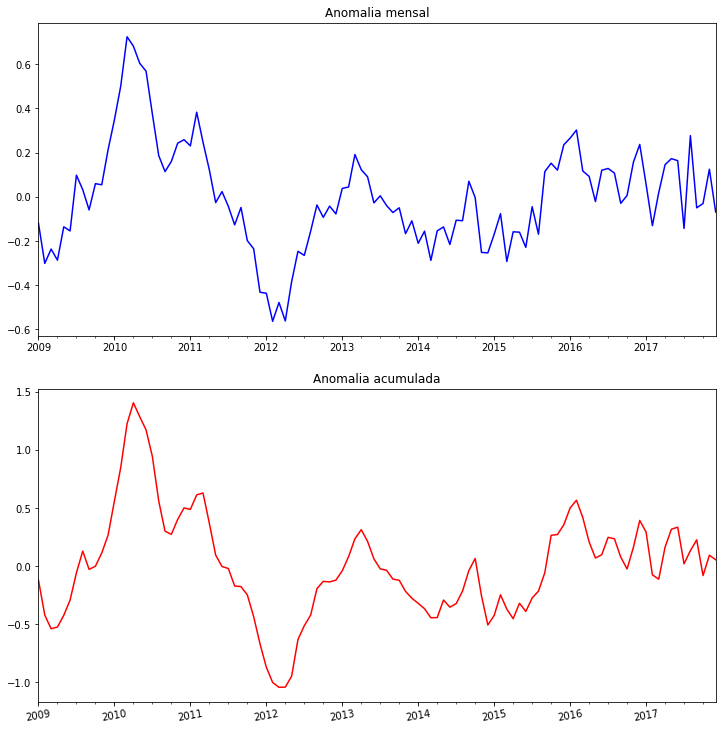

In [9]:
fig, axarr = plt.subplots(2)
fig.set_size_inches(10, 10)

funceme_df[COLUNA_ANOMALIA_DO_MES].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Anomalia mensal')

funceme_df[COLUNA_ANOMALIA_ACUMULADA].plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Anomalia acumulada')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.xticks(rotation=10)
plt.show()
